In [8]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh, ElementTetP2, ElementTetP1

)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import plotly.graph_objects as go
from skfem.mesh import MeshTet # MeshTet para mallas tetraédricas (3D)

In [3]:
mesh = Mesh.load("tubo.msh");

In [7]:
def get_boundary_facets_indices(mesh): 
    boundary_facets_idx = mesh.boundary_facets()
    facets  = mesh.facets
    nodes   = mesh.p
    
    pared_idx   = []
    salida_idx  = []
    entrada_idx = []

    for e in boundary_facets_idx:
        coords_facets = nodes[:, facets[:, e]]
        m = np.mean(coords_facets, axis=1) # m = [mean(x), mean(y), mean(z)]

        # Lógica de Etiquetado (usando Y = m[1] como eje vertical, cerca de -2)
        
        # Pared: Partes que no son la entrada/salida (e.g., Y > -2.0)
        if m[1] > -2.0:
            pared_idx.append(e)
            
        # Salida: Extremo derecho (Y en -2.0 y X > 0)
        elif m[1]==-2.0 and m[0] > 0.0:
            salida_idx.append(e)
            
        # Entrada: Extremo izquierdo (Y en -2.0 y X < 0)
        elif m[1]==-2.0 and m[0] < 0.0:
            entrada_idx.append(e)
            
    return np.array(pared_idx), np.array(salida_idx), np.array(entrada_idx)

wall, outflow, inflow = get_boundary_facets_indices(mesh)

In [10]:
# Graficar malla y boundary facets
facets = mesh.facets
nodes  = mesh.p


def get_mesh_data(indices_facets):  
    if indices_facets.size == 0:
        return None
        
    # Extraer las facetas que corresponden a los índices calculados
    facet_indices = facets[:, indices_facets]
    
    x = nodes[0, :]
    y = nodes[1, :]
    z = nodes[2, :]
    
    i = facet_indices[0, :]
    j = facet_indices[1, :]
    k = facet_indices[2, :]
    
    return x, y, z, i, j, k


traces = []

# Wall
wall_data = get_mesh_data(wall)
if wall_data:
    x, y, z, i, j, k = wall_data
    traces.append(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            color='rgba(0, 200, 0, 0.5)',
            opacity=0.5,
            name='Wall',
            showlegend=True,
            lighting=dict(ambient=0.5, diffuse=0.5, specular=0.8)
        )
    )

# Inflow
inflow_data = get_mesh_data(inflow)
if inflow_data:
    x, y, z, i, j, k = inflow_data
    traces.append(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            color='rgba(200, 0, 0, 0.8)',
            opacity=0.8,
            name='Inflow',
            showlegend=True,
            lighting=dict(ambient=0.5, diffuse=0.5, specular=0.8)
        )
    )

# Outflow
outflow_data = get_mesh_data(outflow)
if outflow_data:
    x, y, z, i, j, k = outflow_data
    traces.append(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            color='rgba(0, 0, 200, 0.8)',
            opacity=0.8,
            name='Outflow',
            showlegend=True,
            lighting=dict(ambient=0.5, diffuse=0.5, specular=0.8)
        )
    )

# Nodos de la malla
traces.append(
    go.Scatter3d(
        x=nodes[0, :],
        y=nodes[1, :],
        z=nodes[2, :],
        mode='markers',
        marker=dict(
            size=1,
            color=nodes[2, :],
            opacity=0.8
        ),
        name='Nodos Malla',
        showlegend=True
    )
)

fig = go.Figure(data=traces)

fig.update_layout(
    title='Malla 3D Interactiva de Fronteras de Tubería en U',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()


## Navier Stokes transiente

In [11]:
# Definir elementos y bases (P2 para velocidad, P1 para presión) en 3D
element = {
    'u': ElementVector(ElementTetP2(), dim=3),
    'p': ElementTetP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [12]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M = asm(mass_matrix, basis_u)
F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F   = np.hstack([F_u, F_p])

In [14]:
# DOFs de las fronteras
dofs_wall   = basis_u.get_dofs(wall).all()
dofs_outflow  = basis_u.get_dofs(outflow).all()
dofs_inflow = basis_u.get_dofs(inflow).all()

dofs_inflow_x = dofs_inflow[dofs_inflow % 3 == 0]
dofs_inflow_y = dofs_inflow[dofs_inflow % 3 == 1]
dofs_inflow_z = dofs_inflow[dofs_inflow % 3 == 2]
dofs_p_salida = basis_p.get_dofs(outflow).all()

xin = basis_u.doflocs[0, dofs_inflow_x]
yin = basis_u.doflocs[1, dofs_inflow_y]
zin = basis_u.doflocs[2, dofs_inflow_z]

x_min = np.min(xin)
x_max = np.max(xin)
z_min = np.min(zin)
z_max = np.max(zin)

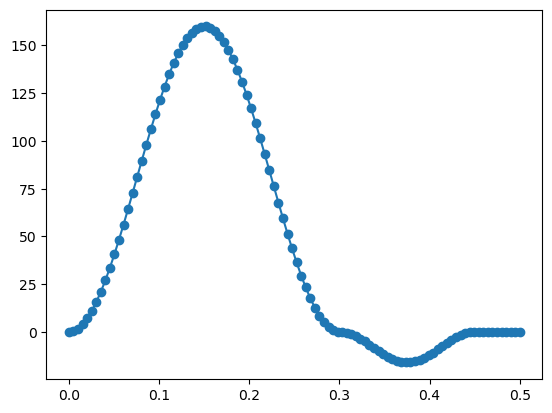

In [17]:
T_s = 0.3
T_d = 0.15
U = -160
U_dia = -16

def f_t(t):
    if t < T_s:
        return U * (np.sin(np.pi * t / T_s))**2
    elif t < T_s + T_d:
        return -U_dia * (np.sin(np.pi * (t - T_s) / T_d))**2
    else:
        return 0.0
    
def u_inflow(t, x, y, z):
    return f_t(t) * (x - x_min) * (x_max - x) * (z - z_min) * (z_max - z)

t = np.linspace(0, 0.5, 100)

plt.plot(t, [-f_t(ti) for ti in t], '-o')
    

In [19]:
x_boundaries = np.zeros(Nu+Np)
x_boundaries[Nu + dofs_p_salida[0]] = 0.0

D_all = np.concatenate([
    basis_u.get_dofs(wall).all(),
    Nu+np.array([dofs_p_salida[0]])
]) 

In [21]:
def apply_inflow(x_boundary, dofs_boundary, xtop, ytop, ztop, t):
    x_boundary[dofs_inflow_y] =  u_inflow(t, xtop, ytop, ztop)  # componente y
    dofs_boundary = np.concatenate([dofs_boundary, dofs_inflow])
    return x_boundary, dofs_boundary

In [25]:
mu      = 0.035
rho     = 1.06
delta_t = 0.001
t       = np.arange(0, 0.5, delta_t)

u_n_1 = np.zeros(Nu)
U_list = []
P_list = []

for ti in t:
    x_b, dofs_b = apply_inflow(x_boundaries, D_all, xin, yin, zin, ti)
    u_0 = basis_u.interpolate(u_n_1)  
    C   = asm(convection, basis_u, w=u_0)

    K = bmat([[M + delta_t*(mu * A + rho*C), delta_t*B.T ],
             [B,         None]], format='csr')
    
    F_u = M@u_n_1
    F = np.hstack([F_u, np.zeros(Np)])

    sol = solve(*condense(K, F, D=dofs_b, x=x_b))

    u_n_1 = sol[:Nu]
    U_list.append(u_n_1)
    P_list.append(sol[Nu:])

In [ ]:
import os
# Interpolar presión a los nodos P1
P1_basis = Basis(mesh, ElementTetP1())

# Crear directorio para los resultados si no existe
output_dir = "resultados_temporales"
os.makedirs(output_dir, exist_ok=True)

# Lista para almacenar las entradas del archivo PVD
pvd_entries = []

# Exportar cada instante de tiempo
for idx, ti in enumerate(t):
    u_ref = U_list[idx]
    p_ref = P_list[idx]

    # Mapeo de Velocidad (Vectorial 3D)
    velocity_vector = np.zeros((mesh.nvertices, 3))
    
    for node_idx in range(mesh.nvertices):
        velocity_vector[node_idx, 0] = u_ref[basis_u.nodal_dofs[0, node_idx]]  # componente X
        velocity_vector[node_idx, 1] = u_ref[basis_u.nodal_dofs[1, node_idx]]  # componente Y
        velocity_vector[node_idx, 2] = u_ref[basis_u.nodal_dofs[2, node_idx]]  # componente Z
    
    point_data_to_export = {
        "velocity": velocity_vector,
        "pressure": p_ref,
    }
    
    # Guardar cada paso de tiempo con un nombre único
    filename = f"stokes3d_t_{idx:04d}.vtu"
    filepath = os.path.join(output_dir, filename)
    mesh.save(filepath, point_data=point_data_to_export)
    
    # Agregar entrada al archivo PVD
    pvd_entries.append(f'    <DataSet timestep="{ti}" file="{filename}"/>')
